In [1]:
import numpy as np
import os
import random
from os.path import join
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LSTM, Bidirectional, TimeDistributed, GRU, CuDNNGRU
from keras.utils import to_categorical
from keras_utils import set_keras_session
from inception_generators import frames_generator_rnn, load_whole_dataset, sparse_frame_generator, extract_n_random_frames
from plot_utils import plot_history

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
set_keras_session()
dataset = 'UCF11'
nb_classes = int(dataset[3:])

In [3]:
frame_number = 50
width = 320
height = 240
channels = 3
padding = None

dataset_name= 'separate_frames_{}_h_{}_w_{}_inception'.format(frame_number, height, width)
if padding is not None:
    dataset_name += '_padding_{}'.format(padding)


dataset_dir = join('datasets', dataset, dataset_name)
(X_train, Y_train), (X_valid, Y_valid) = list(load_whole_dataset(dataset_dir, 'rnn', ['train', 'valid']))
sequence_shape = (frame_number, height, width, channels)
print(X_train.shape)

batch_size = 64
epochs = 100
sparse_gen = sparse_frame_generator(X_train, Y_train, 30, batch_size)
X_valid = np.array([extract_n_random_frames(video, 30) for video in X_valid])

(1126, 50, 2048)


In [4]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.densenet import DenseNet121
from keras.models import Model
from keras import backend as K
from keras import regularizers
from keras.layers import Lambda


l1l2 = regularizers.L1L2(l1=0.0, l2=0.01)

def build_model():
       
    rnn = Sequential()
    rnn.add(Dropout(0.5, input_shape=(X_valid.shape[1:])))
    rnn.add(TimeDistributed(Dense(128, activation='relu')))
    rnn.add(LSTM(512, input_shape=(X_valid.shape[1:]), recurrent_dropout=0.2))
    #rnn.add(Lambda(lambda x: K.mean(x, axis=1)))
    # rnn.add(Dense(128, activation='relu'))
    rnn.add(Dropout(0.8))
    rnn.add(Dense(nb_classes, activation='softmax'))

    return rnn


def build_model_stacked():
       
    rnn = Sequential()
    rnn.add(LSTM(512, input_shape=(X_valid.shape[1:]), recurrent_dropout=0.2, return_sequences=True))
    rnn.add(LSTM(128, input_shape=(X_valid.shape[1:])))
    #rnn.add(Dense(128, activation='relu'))
    rnn.add(Dropout(0.5))
    rnn.add(Dense(nb_classes, activation='softmax'))

    return rnn

In [5]:
from keras import metrics, callbacks, optimizers
from functools import partial

top_3_k_categorical_accuracy = partial(metrics.top_k_categorical_accuracy, k=3)
top_3_k_categorical_accuracy.__name__ = 'top_3'

early_stopper = callbacks.EarlyStopping(patience=5)
reduce_lr = callbacks.ReduceLROnPlateau(patience=5, factor=0.75)

model = build_model()
print(model.summary())

sgd = optimizers.SGD(momentum=0.9, nesterov=True, lr=0.001)
sgd = optimizers.SGD(momentum=0.9, lr=0.001)
adam = optimizers.Adam(lr=0.0001)

model.compile(optimizer=sgd, loss='categorical_crossentropy', 
              metrics=['accuracy', top_3_k_categorical_accuracy])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_1 (Dropout)          (None, 30, 2048)          0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 30, 128)           262272    
_________________________________________________________________
lstm_1 (LSTM)                (None, 512)               1312768   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 11)                5643      
Total params: 1,580,683
Trainable params: 1,580,683
Non-trainable params: 0
_________________________________________________________________
None


In [6]:
# history = model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), 
#           batch_size=64, epochs=500)

history = model.fit_generator(sparse_gen, steps_per_epoch=len(X_train)//batch_size, 
                              validation_data=(X_valid, Y_valid), epochs=epochs)

Epoch 1/100
17/17 [==============================] - 2s 128ms/step - loss: 2.4663 - acc: 0.0919 - top_3: 0.2794 - val_loss: 2.3586 - val_acc: 0.1620 - val_top_3: 0.3689
Epoch 2/100
17/17 [==============================] - 1s 75ms/step - loss: 2.3465 - acc: 0.1526 - top_3: 0.3952 - val_loss: 2.2738 - val_acc: 0.3689 - val_top_3: 0.6141
Epoch 3/100
17/17 [==============================] - 1s 75ms/step - loss: 2.2908 - acc: 0.1801 - top_3: 0.4329 - val_loss: 2.1908 - val_acc: 0.4286 - val_top_3: 0.6503
Epoch 4/100
17/17 [==============================] - 1s 76ms/step - loss: 2.1847 - acc: 0.2767 - top_3: 0.5202 - val_loss: 2.0854 - val_acc: 0.4264 - val_top_3: 0.7164
Epoch 5/100
17/17 [==============================] - 1s 78ms/step - loss: 2.1019 - acc: 0.3401 - top_3: 0.5892 - val_loss: 1.9768 - val_acc: 0.5373 - val_top_3: 0.7612
Epoch 6/100
17/17 [==============================] - 1s 77ms/step - loss: 1.9669 - acc: 0.4164 - top_3: 0.6700 - val_loss: 1.8390 - val_acc: 0.5458 - val_top_3

17/17 [==============================] - 1s 76ms/step - loss: 0.0953 - acc: 0.9697 - top_3: 0.9991 - val_loss: 0.5243 - val_acc: 0.8721 - val_top_3: 0.9787
Epoch 50/100
17/17 [==============================] - 1s 77ms/step - loss: 0.0620 - acc: 0.9862 - top_3: 0.9991 - val_loss: 0.4314 - val_acc: 0.8763 - val_top_3: 0.9659
Epoch 51/100
17/17 [==============================] - 1s 76ms/step - loss: 0.0468 - acc: 0.9899 - top_3: 1.0000 - val_loss: 0.5005 - val_acc: 0.8699 - val_top_3: 0.9723
Epoch 52/100
17/17 [==============================] - 1s 77ms/step - loss: 0.0465 - acc: 0.9890 - top_3: 1.0000 - val_loss: 0.4051 - val_acc: 0.8998 - val_top_3: 0.9680
Epoch 53/100
17/17 [==============================] - 1s 74ms/step - loss: 0.0398 - acc: 0.9908 - top_3: 1.0000 - val_loss: 0.5084 - val_acc: 0.8849 - val_top_3: 0.9723
Epoch 54/100
17/17 [==============================] - 1s 76ms/step - loss: 0.0405 - acc: 0.9926 - top_3: 1.0000 - val_loss: 0.4537 - val_acc: 0.8891 - val_top_3: 0.9787

17/17 [==============================] - 1s 76ms/step - loss: 0.0091 - acc: 1.0000 - top_3: 1.0000 - val_loss: 0.5467 - val_acc: 0.8827 - val_top_3: 0.9680
Epoch 98/100
17/17 [==============================] - 1s 75ms/step - loss: 0.0067 - acc: 1.0000 - top_3: 1.0000 - val_loss: 0.4922 - val_acc: 0.8955 - val_top_3: 0.9723
Epoch 99/100
17/17 [==============================] - 1s 77ms/step - loss: 0.0116 - acc: 0.9982 - top_3: 1.0000 - val_loss: 0.6958 - val_acc: 0.8635 - val_top_3: 0.9510
Epoch 100/100
17/17 [==============================] - 1s 76ms/step - loss: 0.0250 - acc: 0.9945 - top_3: 1.0000 - val_loss: 0.4923 - val_acc: 0.8891 - val_top_3: 0.9808


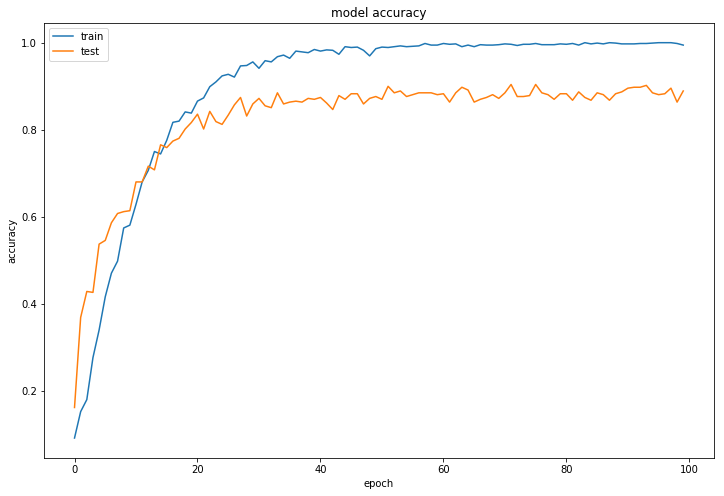

In [7]:
plot_history(history)

In [8]:
sgd = optimizers.SGD(momentum=0.9, lr=0.0005)

model.compile(optimizer=sgd, loss='categorical_crossentropy', 
              metrics=['accuracy', top_3_k_categorical_accuracy])

history = model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), 
          batch_size=64, epochs=50, callbacks=[reduce_lr])

ValueError: Error when checking input: expected dropout_1_input to have shape (30, 2048) but got array with shape (50, 2048)

In [ ]:
np.set_printoptions(threshold=np.nan)
Y_predict = model.predict(X_valid)
class_predict = np.argmax(Y_predict, axis=1)
print(class_predict)

In [ ]:
class_true = np.argmax(Y_valid, axis=1)
print(class_true)

In [ ]:
for idx in range(len(class_true)):
    if class_true[idx] != class_predict[idx]:
        print(idx, 'true:', class_true[idx], '  predict:', class_predict[idx], '  prop_true:', Y_predict[idx][class_true[idx]])
        print(Y_predict[idx])
        print()

In [ ]:
from count_num_frames_on_dataset import get_number_frames_from_video
from inception_generators import get_dataset_split_structure, get_class_to_idx_dict

def dataset_loader_with_frames(dataset_dir, split_key):
    
    base_dir = join(dataset_dir, split_key)
    
    dataset_structure = get_dataset_split_structure(base_dir)
    all_classes = dataset_structure.keys()
    class_to_idx_dict = get_class_to_idx_dict(all_classes)
        
    for cl in all_classes:

        class_idx = class_to_idx_dict[cl]

        for video in dataset_structure[cl]:
            
            # ex: video == v_shooting_22_05.npy   or  video == v_walk_dog_10_01.npy
            
            video_subfolder = video[:video.rfind('_')]
            video_mpg = video[:-3] + 'mpg'
            
            original_video = join('datasets', dataset, 'video', cl, video_subfolder, video_mpg)
            number_frames = get_number_frames_from_video(original_video)

            inception_features = np.load(join(base_dir, cl, video))

            yield inception_features, class_idx, number_frames, video[:-3]
                

def load_whole_dataset_with_frames(dataset_dir, split_key):
        
    data = list(dataset_loader_with_frames(dataset_dir, split_key))
    X, Y, frames, filenames = map(np.array, zip(*data))

    yield X, to_categorical(Y), frames, filenames

In [ ]:
d = list(load_whole_dataset_with_frames(dataset_dir, 'valid'))

In [ ]:
X_valid_2, Y_valid_2, frames, filenames = zip(*d)

In [ ]:
X_valid_2, Y_valid_2, frames, filenames = X_valid_2[0], Y_valid_2[0], frames[0], filenames[0]

In [ ]:
Y_predict = model.predict(X_valid_2)
class_predict = np.argmax(Y_predict, axis=1)
print(class_predict)

In [ ]:
class_true = np.argmax(Y_valid_2, axis=1)
print(class_true)

In [ ]:
frames_incorrect = []
class_incorrect = []

for idx in range(len(class_true)):
    if class_true[idx] != class_predict[idx]:
        print(idx, 'true:', class_true[idx], '  predict:', class_predict[idx], '  prop_true:', Y_predict[idx][class_true[idx]])
        print('num_frames:', frames[idx], 'filename:', filenames[idx])
        print(Y_predict[idx])
        print()
        frames_incorrect.append(frames[idx])
        class_incorrect.append(class_true[idx])

In [ ]:
class_train = np.argmax(Y_train, axis=1)

In [ ]:
from collections import Counter

Counter(class_train)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))


plt.subplot(121)
plt.title('Number of frames inside validation set')
plt.hist(frames)


plt.subplot(122)
plt.title('Number of frames of incorrect predicted validation videos')
plt.hist(frames_incorrect)

In [ ]:
plt.figure(figsize=(10, 6))

plt.subplot(121)
plt.hist(np.argmax(Y_valid, axis=1))

plt.subplot(122)
plt.hist(class_incorrect)

In [ ]:
plt.hist(np.argmax(Y_train, axis=1))

In [ ]:
d = list(load_whole_dataset_with_frames(dataset_dir, 'train'))

In [ ]:
X_train_2, Y_train_2, frames_train, filenames_train = zip(*d)

In [ ]:
plt.hist(frames_train[0][frames_train[0] < 600])

In [ ]:
frames_0 = X_train[0]
frames_2 = X_train[1]
frames_1 = X_train[-1]

In [ ]:
np.sum(np.std(frames_0[0:50], axis=0))

In [ ]:
np.sum(np.std(np.concatenate([frames_2[0:25], frames_1[:25]]), axis=0))

In [ ]:
np.sum(np.std(np.concatenate([frames_0[0:25], frames_2[:25]]), axis=0))